In [558]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import squarify
from wordcloud import WordCloud, STOPWORDS

In [559]:
# Create a data frame out of the Corpus del Español.
corpus = pd.read_csv("Corpus_voc_pro.csv", header=None)

# Import text (example.txt) to analize and assign text into a variable
text = open("example.txt", "r", encoding="utf8")
content = text.read()

In [560]:
#Create list of tokens - words and symbols - extracted from text with all characters:
char_list = content.split()

In [561]:
#Create function to remove all characters that are not part of the Spanish alphabet (keep accent marks)
def symbol_free(list):
    word_list = []
    for i in list:
        new_word = re.sub("[^a-zA-ZñÑáéíóúÁÉÍÓÚ]+", "", i)
        if new_word != "":
            word_list.append(new_word)
    return word_list

In [562]:
#Apply function to the list of tokens with all characters
word_list = symbol_free(char_list)

In [563]:
# Make all words lower case
word_list = [each_string.lower() for each_string in word_list]

In [564]:
#Convert list into Pandas data frame
words = pd.DataFrame(word_list)

In [565]:
words.head()

,0
0,haciendo
1,algo
2,que
3,desde
4,hacía


In [566]:
# Create dataframe with nonduplicated words
words_unique = words.drop_duplicates(subset=None, keep='first', ignore_index=False)

In [567]:
#Merge word_unique data frame with corpus data frame to have corpus frequency of each word
df1 = words_unique.merge(corpus, how="left", on=[0])
df1.dropna(axis = 0, inplace=True)

In [568]:
# Drop second duplicate occurences of word
df_unique = df1.drop_duplicates(subset=[0], keep='first')

In [569]:
#Merge word dataframe frame with df_unique to have corpus frequency of each word
df = words.merge(df_unique, how="left", on=[0])

In [570]:
#df.dropna(axis = 0, inplace=True)
df = df.rename(columns={0: "token", 1: "freq_order" })

In [571]:
df.shape

(530, 2)

In [572]:
df.head()

,token,freq_order
0,haciendo,436.0
1,algo,126.0
2,que,6.0
3,desde,57.0
4,hacía,381.0


In [573]:
# Create data frame for bucketing count
freq = np.array([["1 to 300", 0], ["301 to 1000", 0], ["1001 to 3000" , 0], ["3001 to 5000" , 0],
              ["5001 to 10000", 0], ["10001 to 50000", 0], ["50001 and higher", 0], ["Too infrequent proper nouns", 0]])
token_freq_all = pd.DataFrame(freq, columns = ['Frequency in corpus', 'Number of tokens per frequency'])

# Define number of tokens with particular frequency.
tk = token_freq_all['Number of tokens per frequency']
tk[0] = df.query("freq_order > 0 and freq_order <= 300").count()[0]
tk[1] = df.query("freq_order > 300 and freq_order <= 1000").count()[0]
tk[2] = df.query("freq_order > 1000 and freq_order <= 3000").count()[0]
tk[3] = df.query("freq_order > 3000 and freq_order <= 5000").count()[0]
tk[4] = df.query("freq_order > 5000 and freq_order <= 10000").count()[0]
tk[5] = df.query("freq_order > 10000 and freq_order <= 50000").count()[0]
tk[6] = df.query("freq_order > 50000").count()[0]
tk[7] = df.query("freq_order == 'NaN'").count()[0]

In [574]:
# Writing a csv file with all the vocabulary profile for these 9 buckets.
token_freq_all.to_csv('freq_profile.csv', index=False, index_label=None)

In [575]:
# Convert token_freq_all["Number of tokens per frequency"] into integers
token_freq_all["Number of tokens per frequency"] = token_freq_all["Number of tokens per frequency"].astype(int)

In [576]:
token_freq_all

,Frequency in corpus,Number of tokens per frequency
0,1 to 300,322
1,301 to 1000,61
2,1001 to 3000,41
3,3001 to 5000,13
4,5001 to 10000,25
5,10001 to 50000,50
6,50001 and higher,6
7,Too infrequent proper nouns,12


In [577]:
# Eliminate rows with 0 and "too infrequent proper nouns"
token_freq_no_zero = token_freq_all[token_freq_all['Number of tokens per frequency'] > 0]
token_freq_no_proper = token_freq_no_zero.drop(token_freq_no_zero[token_freq_no_zero["Frequency in corpus"] == 
                                                        'Too infrequent proper nouns'].index)

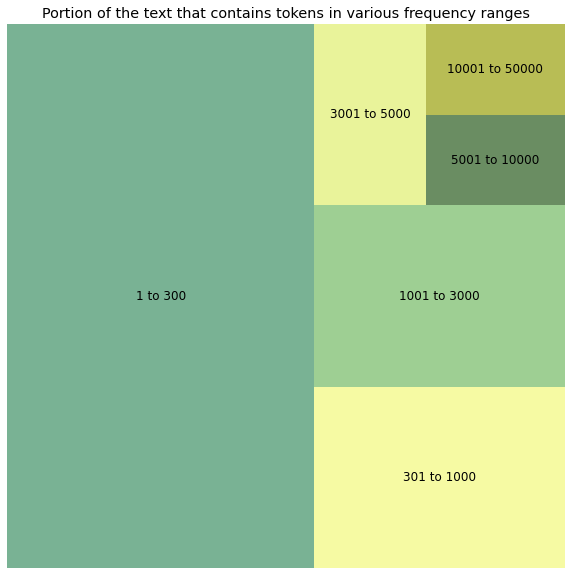

In [578]:
# Visualizations:
# (i) Treemap with number of tokens in each frequency range
#volume = token_freq["Number of tokens per frequency"]
volume = token_freq["Number of tokens per frequency"]
labels = token_freq["Frequency in corpus"]
color_list = ['#419267', '#f3f87d', '#76bb66','#e0ef70','#2b5d20','#9ba10d','#91dfb6']


fig = plt.figure(figsize=[10,10])
plt.rc('font', size=12)
squarify.plot(sizes=volume, label=labels, color=color_list, alpha=0.7)
plt.axis('off')
plt.title("Portion of the text that contains tokens in various frequency ranges")

#plt.show()
plt.savefig('treemap.png',dpi = 80, bbox_inches= "tight", pad_inches=0.3)


In [579]:
# (ii) number of tokens, lexical variability, lexical density

In [580]:
# Import file to calculate lexical density
categ = pd.read_csv("corpus_category.csv", sep=";")

In [581]:
# Eliminate duplicated values that are too infrequent
category = categ.drop_duplicates(subset="token", keep='first')

In [582]:
# Combine category and df
result = pd.merge(df, category, on="token")

In [583]:
result.head()

,token,freq_order,orden,cat1,lema
0,haciendo,436.0,436,v,hacer
1,haciendo,436.0,436,v,hacer
2,haciendo,436.0,436,v,hacer
3,algo,126.0,126,p,algo
4,que,6.0,6,c,que


In [584]:
# Calculate lexical density (number of unique content words)
density = result.query("cat1 == 'v' or cat1 == 'n' or cat1 == 'j' or cat1 =='r'")

In [585]:
density

,token,freq_order,orden,cat1,lema
0,haciendo,436.0,436,v,hacer
1,haciendo,436.0,436,v,hacer
2,haciendo,436.0,436,v,hacer
25,hacía,381.0,381,v,hacer
26,hacía,381.0,381,v,hacer
...,...,...,...,...,...
511,estirpes,57587.0,57587,n,estirpe
512,condenadas,32382.0,32382,j,condenado
514,tenían,554.0,554,v,tener
516,oportunidad,872.0,872,n,oportunidad


In [586]:
# Create dataframe with n tokens, lex dens, and lex var
info = {'Feature': ["Total number of tokens", "Tokens for lexical variability", "Tokens for lexical density"], 
          'Proportion': [df["token"].count(), df["token"].nunique(), density["token"].nunique()]}
bar_df = pd.DataFrame(data=info)

bar_df

,Feature,Proportion
0,Total number of tokens,530
1,Tokens for lexical variability,268
2,Tokens for lexical density,198


In [587]:
# Writing a csv file with all the vocabulary profile for these 3 categories.
bar_df.to_csv('totals.csv', index=False, index_label=None)

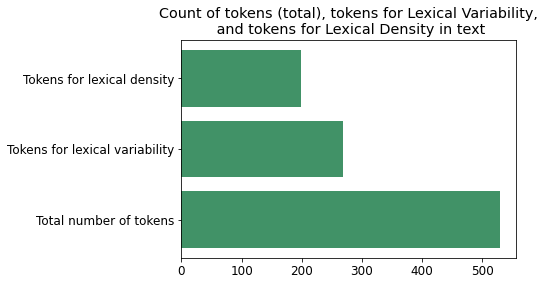

In [588]:
# Create simple horixontal barplot for n tokens, lex dens, and lex var
plt.barh(data=bar_df, y="Feature", width="Proportion", color='#419267')
plt.title("Count of tokens (total), tokens for Lexical Variability,\n and tokens for Lexical Density in text")
#plt.show()
plt.savefig('barchart.png', dpi=80, bbox_inches= "tight", pad_inches=0.3);

In [589]:
# (iii) word cloud
density_dict = density[["token","freq_order"]]

In [590]:
comment_words = ''
# stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in density_dict.token:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "

In [594]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, collocations=False).generate(comment_words)

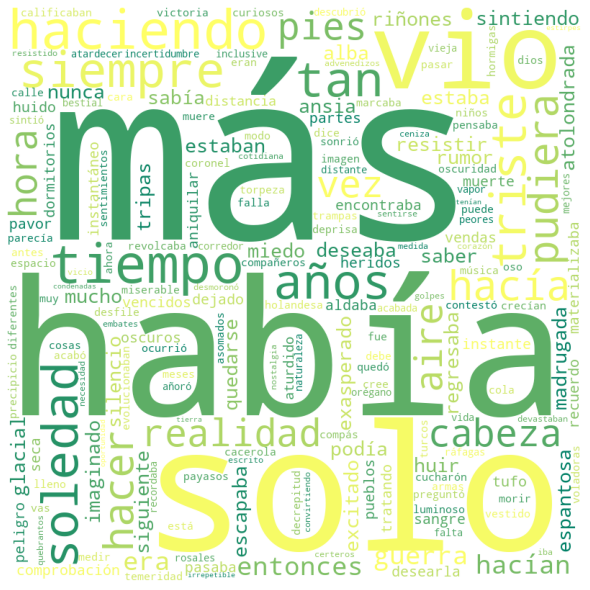

In [596]:
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud.recolor(colormap= "summer"))
plt.axis("off")
plt.tight_layout(pad = 0)
  
#plt.show()
plt.savefig('wordcloud.png',dpi=80, bbox_inches= "tight", pad_inches=0.3)